# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving informaton out of natural language (could be seqeuences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

> 📖 Resource: See all course materials, resources and extra-curriculum for this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4d1cf25d-63b9-6b11-6bc0-30c7b7ebb93e)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-07-23 19:35:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-23 19:35:50 (73.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a test dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as diaster or not diaster).

See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-07-23 19:35:58--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2022-07-23 19:35:58 (39.1 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python 

But I prefer to get visuals straight away.

So another way to do this is to use pandas...

In [5]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffeld = train_df.sample(frac=1, random_state=42)
train_df_shuffeld.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not heigher than the total number of samples
for row in train_df_shuffeld[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 0 (not real disaster)
Text:
VINE OF THE YEAR OH MY GOD I AM ABOUT TO EXPLODE https://t.co/cnxXmfFRae

---

Target: 1 (real disaster)
Text:
We have overrun a Natural Disaster Survival server!

---

Target: 0 (not real disaster)
Text:
@asukager magical bag of blazing

---

Target: 1 (real disaster)
Text:
Media Release - Firefighters Ask Hikers to Sign-in at Local Trailheads (Parker Ridge Wildfire): Parker... http://t.co/ABlz20mgzv #IDFire

---

Target: 1 (real disaster)
Text:
Ashley and I on going to hurricane harbor Friday. ?? http://t.co/ScEfPFvAEU

---



### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffeld["text"].to_numpy(),
                                                                           train_df_shuffeld["target"].to_numpy(),
                                                                           test_size=0.1, # use 10% of training data for validation step
                                                                           random_state=42)

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:

* Tokenziation - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [15]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=None)

In [17]:
len(train_sentences[0].split())

7

In [18]:
# Find the average number of tokens (words) in the training tweets

round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [19]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [20]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [21]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [22]:
# Choose a random sentence from the training dataset and tokwnize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 New post: Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/LWDcrPEhTN

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 50, 371, 618,   6, 634, 206, 534,  87, 189,  65, 551, 108,   4,
        613, 164]])>

In [23]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [24]:
train_sentences

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vetor 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [25]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, #set input shape
                            output_dim=128,
                             embeddings_initializer="uniform",
                            input_length=max_length) # how long is each input
                             
embedding                    

In [26]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\n\nEmbedded version:")

# Embed the random sentence (turn it into dense vetros for fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Three Israeli soldiers wounded in West Bank terrorist attack - Haaretz http://t.co/u4gSBNU8wc

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04714278,  0.00282634, -0.01206606, ..., -0.04479844,
         -0.00134015, -0.03054755],
        [ 0.03096093, -0.0274388 ,  0.00200467, ...,  0.04000692,
          0.02383599, -0.00639518],
        [-0.00252933,  0.03835492,  0.04185839, ...,  0.0484421 ,
         -0.0364113 ,  0.00486457],
        ...,
        [ 0.03231761,  0.03818372,  0.01340393, ..., -0.02772989,
         -0.04249896, -0.0213354 ],
        [ 0.03231761,  0.03818372,  0.01340393, ..., -0.02772989,
         -0.04249896, -0.0213354 ],
        [ 0.03231761,  0.03818372,  0.01340393, ..., -0.02772989,
         -0.04249896, -0.0213354 ]]], dtype=float32)>

In [27]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.04714278,  0.00282634, -0.01206606,  0.04976441,  0.00903946,
         0.00655327, -0.00733745, -0.01616669, -0.00913808, -0.00613379,
         0.02079118,  0.02135492,  0.04583918,  0.0329656 , -0.01314765,
         0.01202144,  0.00221753, -0.02568131, -0.04478222,  0.01565507,
         0.00386276,  0.02105166,  0.01330227,  0.01830352,  0.04666907,
        -0.04140463,  0.01596079,  0.00866417, -0.02735288, -0.02228075,
         0.0223099 , -0.01737777,  0.04459887, -0.03304619,  0.02654446,
         0.03290944,  0.0251064 , -0.02652744,  0.03228167,  0.03118474,
         0.0194355 ,  0.03381577,  0.02895551, -0.01577811,  0.04500482,
         0.01875201, -0.00659649, -0.04819039,  0.01228352,  0.01791305,
        -0.03447691, -0.04919255, -0.03688556, -0.03472571,  0.01736783,
         0.04861793, -0.01288161, -0.00843682, -0.0254488 ,  0.02194757,
        -0.00815175,  0.014413  ,  0.04222249,  0.01220461,  0.01160074,
  

## Modelling a text dataset (setting up our modelling experiments)
Now we've got our data in numerical format, let's start building and comparing different models.

* Model 0: Naive Bayes (baseline) - got this from here: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional LSTM
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Word Embedding (feature extractor)
* Model 7: Same as model 6 but using 10% of data

For each of these models, we're going to be following the TensorFlow steps in modelling:

* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Mulinomial Naive Bayes using the TF-IDF formular to convert our words to numbers

> **note:** It's common practive to use non-DL algorithms because of their speed and then later using DL to see if you can improve upon them.

In [28]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
                    ("clf", MultinomialNB()) # model the text converted to numbers
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

CPU times: user 130 ms, sys: 3.88 ms, total: 133 ms
Wall time: 147 ms


In [29]:
# Let's evalaute our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [30]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation funciton for our model experiments

We could evaluate all of our model's predictions with different metrics every time, hoverver, this will be cumbersome and could easily be fixed with a function.

Let's make a function to evaluate our modelling experiment predictions using:

* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluation methods, see the Sklearn documentation

In [31]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    
    return model_results

In [32]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: Feed-forward neural network (dense model)

In [33]:
# Create a tensorboard callback (need to create a new on for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [34]:
# Build model with the Funcitonal API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activaiton
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [35]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [36]:
# Compile model
model_1.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [37]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                             y=train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                   experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220723-193705
Epoch 1/5
215/215 [==============================] - 5s 5ms/step - loss: 0.6117 - accuracy: 0.7022 - val_loss: 0.5356 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4419 - accuracy: 0.8199 - val_loss: 0.4711 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3474 - accuracy: 0.8608 - val_loss: 0.4599 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2849 - accuracy: 0.8914 - val_loss: 0.4661 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2375 - accuracy: 0.9124 - val_loss: 0.4842 - val_accuracy: 0.7861


In [38]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4842 - accuracy: 0.7861


[0.48424479365348816, 0.7860892415046692]

In [39]:
# Make some predicitons and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [40]:
# look at a single prediction
model_1_pred_probs[0]

array([0.3522269], dtype=float32)

In [41]:
# Look at the first 10 prediciotns
model_1_pred_probs[:10]

array([[0.3522269 ],
       [0.69666296],
       [0.99741757],
       [0.12168834],
       [0.09653103],
       [0.9307858 ],
       [0.9123904 ],
       [0.9920284 ],
       [0.96041244],
       [0.25473028]], dtype=float32)

In [42]:
# Convert model_1 pred probs from probabilities to prediction labels
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [43]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [44]:
# Evaluate model_1 with our evaluation function
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'f1': 0.7827032509906072,
 'precision': 0.7920916944370863,
 'recall': 0.7860892388451444}

In [45]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [46]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [47]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [48]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [49]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and ebedding_dim (output_dim of our ebedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let#s see how we can visualize it.

To do so , TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And TensorFlow also has an increadible guide on word embeddings themsleves: https://www.tensorflow.org/text/guide/word_embeddings

In [50]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [51]:
# Let's download the saved embeddings locally
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a prevoius input to aid the representation of a later input.

If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modelling lecture https://youtu.be/qjrad0V0uJE
- Chris Olah's intro to LSTMs . https://colah.lgithub.io/posts/2015-08.Understanding-LSTMs/
- Anfrej Karpathy's the unreasonable effectiveness of recurrent neural networks: http://karpathy.github.io/2015/05/21/rnn_effectiveness/

### Model 2: LSTM

* LSTM = long short-term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:
```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [52]:
# Create an LSTTM model 
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [53]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [54]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [55]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220723-193754
Epoch 1/5
215/215 [==============================] - 6s 8ms/step - loss: 0.2215 - accuracy: 0.9178 - val_loss: 0.5589 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1547 - accuracy: 0.9419 - val_loss: 0.6815 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1292 - accuracy: 0.9523 - val_loss: 0.6280 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1042 - accuracy: 0.9623 - val_loss: 0.7806 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0868 - accuracy: 0.9677 - val_loss: 0.7855 - val_accuracy: 0.7795


In [56]:
# Make predicitions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[0.04017448],
       [0.8162591 ],
       [0.9997664 ],
       [0.08393122],
       [0.00104101],
       [0.9952844 ],
       [0.7432232 ],
       [0.99984133],
       [0.99971074],
       [0.3864933 ]], dtype=float32)

In [57]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [58]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 77.95275590551181,
 'f1': 0.7762737227239795,
 'precision': 0.7845315890997154,
 'recall': 0.7795275590551181}

In [59]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [60]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#x = layers.GRU(64, return_sequences=True)(x) # if you wnat to stack recurrent layers on top of each other, you need return_sequences=True
#x = layers.LSTM(64, return_sequences=True)(x)
#x = layers.GRU(64)(x)
#x = layers.Dense(64, activation="relu")(x)
outputs= layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs)

In [61]:
# Get a summary
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
___________________________________________________

In [62]:
# Compile model_3 (GRU)
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220723-193806
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1525 - accuracy: 0.9384 - val_loss: 0.8171 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0836 - accuracy: 0.9677 - val_loss: 0.8104 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0706 - accuracy: 0.9747 - val_loss: 0.8220 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0599 - accuracy: 0.9745 - val_loss: 1.0609 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0549 - accuracy: 0.9769 - val_loss: 1.2458 - val_accuracy: 0.7703


In [64]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[5.12582250e-04],
       [8.60261202e-01],
       [9.99730527e-01],
       [3.77818979e-02],
       [1.00649195e-04],
       [9.99002993e-01],
       [8.35016906e-01],
       [9.99874115e-01],
       [9.99814689e-01],
       [8.36950719e-01]], dtype=float32)

In [65]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [66]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                   y_pred=model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'f1': 0.7670319394766162,
 'precision': 0.7747218290861607,
 'recall': 0.7703412073490814}

In [67]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right.

In [68]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [69]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [70]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [71]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                             train_labels,
                              epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220723-193816
Epoch 1/5
215/215 [==============================] - 7s 11ms/step - loss: 0.1088 - accuracy: 0.9642 - val_loss: 0.8898 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0552 - accuracy: 0.9761 - val_loss: 1.2817 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0467 - accuracy: 0.9778 - val_loss: 1.3587 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0446 - accuracy: 0.9794 - val_loss: 1.5415 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0422 - accuracy: 0.9806 - val_loss: 1.4434 - val_accuracy: 0.7638


In [72]:
# Make predictrions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[2.5806685e-03],
       [7.5095820e-01],
       [9.9993336e-01],
       [1.6450806e-01],
       [1.4782465e-05],
       [9.9847001e-01],
       [7.6507193e-01],
       [9.9996448e-01],
       [9.9995089e-01],
       [9.7798538e-01]], dtype=float32)

In [73]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [74]:
# Calculate results of our biderctional model
model_4_results = calculate_results(y_true=val_labels,
                                   y_pred=model_4_preds)
model_4_results

{'accuracy': 76.37795275590551,
 'f1': 0.7615024149378589,
 'precision': 0.7654647714490235,
 'recall': 0.7637795275590551}

In [75]:
model_3_results

{'accuracy': 77.03412073490814,
 'f1': 0.7670319394766162,
 'precision': 0.7747218290861607,
 'recall': 0.7703412073490814}

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've used Conv2D for out image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) -> (typically Conv1D + polling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

For more of a deep dive into what goes on behind the scenes in a CNN for text (or sequences) see the paper: https://arxiv.org/abs/1809.08037

In [77]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                       kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                       strides=1, # default
                        activation="relu",
                       padding="valid") # default = "valid", the output is smaller than the input shape, "same" means output is same shape as input
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most importatn feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [78]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.0021734 , -0.01474024,  0.0415094 , ...,  0.01800317,
         -0.02486614,  0.03545271],
        [ 0.0192288 , -0.01013782, -0.00359519, ..., -0.01699286,
         -0.00512984, -0.03856626],
        [ 0.05883573,  0.03152779, -0.01098239, ...,  0.04466289,
         -0.03350477, -0.01066831],
        ...,
        [ 0.02638223,  0.01705542,  0.0271484 , ..., -0.00813323,
         -0.01668363,  0.00467193],
        [ 0.02638223,  0.01705542,  0.0271484 , ..., -0.00813323,
         -0.01668363,  0.00467193],
        [ 0.02638223,  0.01705542,  0.0271484 , ..., -0.00813323,
         -0.01668363,  0.00467193]]], dtype=float32)>

In [79]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.        , 0.01989714, 0.02492907, 0.00150162, 0.13488322,
         0.02956791, 0.        , 0.00093755, 0.        , 0.01771871,
         0.07900808, 0.        , 0.        , 0.07496732, 0.        ,
         0.        , 0.039565  , 0.01781571, 0.        , 0.        ,
         0.        , 0.        , 0.01232891, 0.01416742, 0.06087876,
         0.05288689, 0.        , 0.00598588, 0.01131765, 0.        ,
         0.        , 0.        ],
        [0.01369479, 0.06328436, 0.        , 0.        , 0.08067419,
         0.        , 0.        , 0.04561277, 0.04659316, 0.        ,
         0.        , 0.        , 0.07643662, 0.        , 0.        ,
         0.        , 0.0157858 , 0.01574135, 0.05454152, 0.        ,
         0.        , 0.        , 0.02698324, 0.        , 0.00740672,
         0.00535417, 0.        , 0.0301295 , 0.        , 0.        ,
         0.        , 0.00594084],
        [0.        , 0.        , 0.        , 0.0134

In [80]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.0202425 , 0.06971025, 0.03220574, 0.01809837, 0.13488322,
        0.02956791, 0.00468776, 0.04561277, 0.04659316, 0.01771871,
        0.09249318, 0.        , 0.07643662, 0.07496732, 0.0059802 ,
        0.        , 0.039565  , 0.04935838, 0.05454152, 0.04759628,
        0.05516487, 0.        , 0.05303116, 0.01416742, 0.06087876,
        0.05288689, 0.06599177, 0.0301295 , 0.02457783, 0.        ,
        0.04800838, 0.00594084]], dtype=float32)>

In [81]:
# Create 1-dimensional convolutional layer to model sequence
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [82]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                             train_labels,
                              epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220723-193904
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.1226 - accuracy: 0.9591 - val_loss: 0.9178 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0739 - accuracy: 0.9727 - val_loss: 1.0163 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0628 - accuracy: 0.9756 - val_loss: 1.1165 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0547 - accuracy: 0.9756 - val_loss: 1.2162 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0515 - accuracy: 0.9796 - val_loss: 1.2462 - val_accuracy: 0.7572


In [83]:
# Make predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.3504279e-01],
       [7.8794885e-01],
       [9.9985182e-01],
       [9.9180505e-02],
       [1.9445883e-08],
       [9.9441695e-01],
       [9.6510416e-01],
       [9.9997604e-01],
       [9.9999905e-01],
       [8.7019205e-01]], dtype=float32)

In [84]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [85]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                   y_pred=model_5_preds)
model_5_results

{'accuracy': 75.7217847769029,
 'f1': 0.7548067945124027,
 'precision': 0.7588431452858484,
 'recall': 0.7572178477690289}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

> 📖 **Resource:** TensorFlow Hub is a great resource for many pretrained models but HuggingFace is also another incredible resource for many pretrained NLP models (using HuggingFace model is beyond the scope of this course but it is definitely something you should be familiar with in the NLP space): https://huggingface.co/models

In [86]:
sample_sentence

"There's a flood in my street!"

In [87]:
import tensorflow_hub as hub
tf.compat.v1.enable_resource_variables()
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [89]:
embed_samples[0].shape

TensorShape([512])

In [90]:
# Create a Keras Layer using the USE pretreined layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [102]:
# Create model using the Sequential API
from tensorflow.keras import Sequential
model_6 = Sequential([
                      sentence_encoder_layer,
                      layers.Dense(64, activation="relu"),
                      layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [103]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220723-195403
Epoch 1/5
215/215 [==============================] - 4s 14ms/step - loss: 0.5012 - accuracy: 0.7729 - val_loss: 0.4535 - val_accuracy: 0.8071
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4145 - accuracy: 0.8168 - val_loss: 0.4411 - val_accuracy: 0.8150
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4019 - accuracy: 0.8200 - val_loss: 0.4425 - val_accuracy: 0.8058
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3950 - accuracy: 0.8263 - val_loss: 0.4305 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3868 - accuracy: 0.8291 - val_loss: 0.4257 - val_accuracy: 0.8163


In [104]:
# Make predictions with USE TF Hub Model
model_6_pred_prods = model_6.predict(val_sentences)
model_6_pred_prods[:10]

array([[0.1842708 ],
       [0.81215787],
       [0.98620075],
       [0.21196696],
       [0.7487997 ],
       [0.73698145],
       [0.98339796],
       [0.97948223],
       [0.9441534 ],
       [0.11900651]], dtype=float32)

In [105]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_prods))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [106]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'f1': 0.8157217027284339,
 'precision': 0.8163098416789168,
 'recall': 0.8162729658792651}

In [107]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [111]:
# ## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET 

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffeld[["text", "target"]].sample(frac=0.1, random_state=42)
# # train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

> 🔑 **Note:** Be very careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [124]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [134]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [125]:
# Check the number of targets in our subset of data
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [126]:
train_df_shuffeld["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you've created you can use the `tf.keras.models.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [127]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")                               
], name="model_7_USE")

# Compile model
model_7. compile(loss="binary_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [128]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20220723-202258
Epoch 1/5
22/22 [==============================] - 2s 41ms/step - loss: 0.6669 - accuracy: 0.7051 - val_loss: 0.6448 - val_accuracy: 0.7323
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5934 - accuracy: 0.8044 - val_loss: 0.5845 - val_accuracy: 0.7598
Epoch 3/5
22/22 [==============================] - 0s 22ms/step - loss: 0.5168 - accuracy: 0.8131 - val_loss: 0.5350 - val_accuracy: 0.7677
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4599 - accuracy: 0.8204 - val_loss: 0.5028 - val_accuracy: 0.7717
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4191 - accuracy: 0.8307 - val_loss: 0.4901 - val_accuracy: 0.7703


In [129]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.21530229],
       [0.586437  ],
       [0.9191542 ],
       [0.34994954],
       [0.5375654 ],
       [0.67805517],
       [0.887771  ],
       [0.8225485 ],
       [0.86622053],
       [0.16108194]], dtype=float32)

In [130]:
# Turn pre probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [131]:
# Evalaute model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.03412073490814,
 'f1': 0.7689180260110319,
 'precision': 0.7708102089179978,
 'recall': 0.7703412073490814}

## Comparing the performance of aeach of our models

In [138]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.608924,0.792092,0.786089,0.782703
2_lstm,77.952756,0.784532,0.779528,0.776274
3_gru,77.034121,0.774722,0.770341,0.767032
4_bidirectional,76.377953,0.765465,0.763780,0.761502
5_conv1d,75.721785,0.758843,0.757218,0.754807
6_tf_hub_use_encoder,81.627297,0.816310,0.816273,0.815722
7_tf_hub_use_encoder_10_percent,77.034121,0.770810,0.770341,0.768918


In [139]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.786089,0.792092,0.786089,0.782703
2_lstm,0.779528,0.784532,0.779528,0.776274
3_gru,0.770341,0.774722,0.770341,0.767032
4_bidirectional,0.763780,0.765465,0.763780,0.761502
5_conv1d,0.757218,0.758843,0.757218,0.754807
6_tf_hub_use_encoder,0.816273,0.816310,0.816273,0.815722
7_tf_hub_use_encoder_10_percent,0.770341,0.770810,0.770341,0.768918


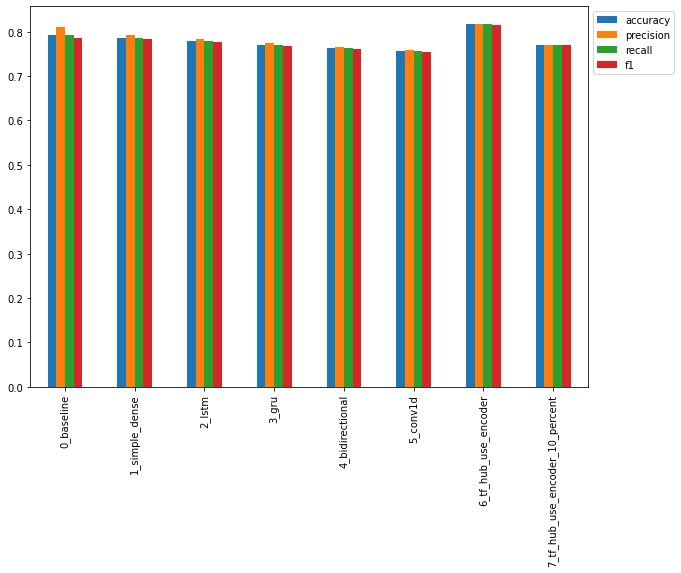

In [140]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

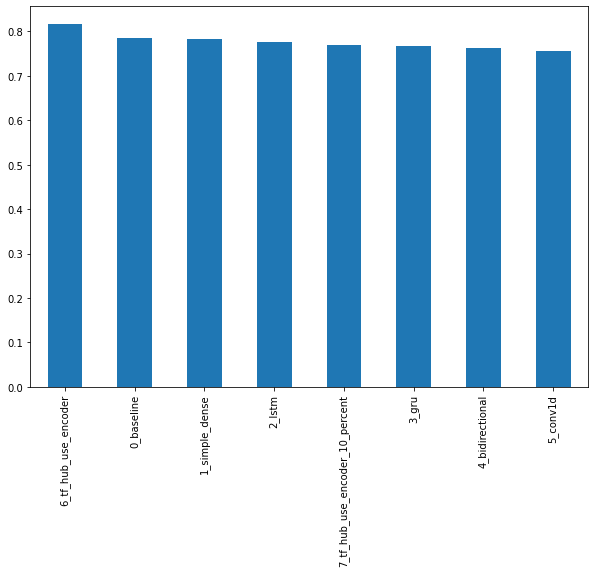

In [142]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

## Uploading our model training logs to TesnorBoard.dev

We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [143]:
# # View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs/ \
#   --name "NLP Modelling Experiments ZTM TF Course Video" \
#   --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
#   --one_shot # exit the uploader once uploading is finished

Now I've ran the cell above, my modelling experiments are visable on TensorBoard.dev: https://tensorboard.dev/experiment/Eacboed3RbKPWIGcXe1Z6g/

> 📖 **Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check out Weights & Biases: https://wandb.ai/site

In [144]:
# # See the previous TensorBoard Dev experiments you've run...
# !tensorboard dev list

In [145]:
# If you need to delete an experiment from TensorBoard, you can run the following:
# !tensorboard dev delete --experiment_id Eacboed3RbKPWIGcXe1Z6gB

## Saving and loading a trained model
There are two main formats to save a model to in TensorFlow:

1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [ ]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

In [ ]:
# Save TF Hub Sentence Ecnoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [ ]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

## Finding the most wrong examples
* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting most wrong (those will predicition probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [146]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-07-23 21:04:05--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   101MB/s    in 7.2s    

2022-07-23 21:04:12 (127 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.i

In [147]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [149]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [150]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [153]:
# find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are flase positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [154]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's remind ourselves of the target labels...

* `0` = no disaster
* `1` = disaster

In [155]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132277488708
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [156]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.055075809359550476
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 

In [157]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## Make predictions on the test dataset

In [158]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

Pred: 0, Prob: 0.2613731920719147
Text:
Let's be thankful most of these injuries are minor &amp; it's still camp. Relax a little #birdgang. No one is cursed &amp; no injury bug hit.

-----

Pred: 0, Prob: 0.25849032402038574
Text:
Chrysler Jeep wirelessly hacked over internet to hijack steering brakes and transmission face lawsuit - should all consider #ISO27001

-----

Pred: 1, Prob: 0.8956475257873535
Text:
We dont really talk about the murder of the bombing campaigns in WWII because we won but murder it is. https://t.co/jsGwnY6kdJ

-----

Pred: 1, Prob: 0.9776012897491455
Text:
The day Hiroshima through the eyes of the bomber crew and survivors http://t.co/AYEWJ8marn via @MailOnline

-----

Pred: 1, Prob: 0.9250620603561401
Text:
Harper Woods policeman injured in fight after dead man found in garage: Ronnie Karjo 46 of Macomb Township http://t.co/tUoTICilBi

-----

Pred: 1, Prob: 0.8565346002578735
Text:
#Kids going to #school amidst the #desolation of an #earthquake #aftermath #Lov

## The speed/score tradeoff

In [163]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make prediciotns on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # caclculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [164]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.383794344999842, 0.0005036671194223649)

In [165]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.029377555999417382, 3.855322309634827e-05)

In [166]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

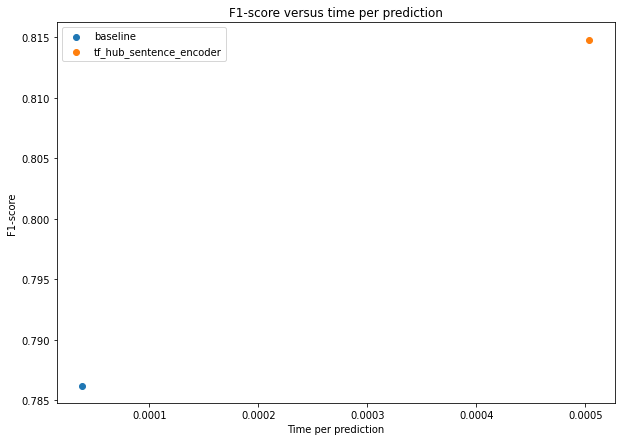

In [167]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");